In [39]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("surajghuwalewala/ham1000-segmentation-and-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ham1000-segmentation-and-classification


In [40]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

dataset_path = "/kaggle/input/ham1000-segmentation-and-classification/versions/2"

# List files in the dataset directory
print("Dataset contents:", os.listdir(path))


Dataset contents: ['GroundTruth.csv', 'images', 'masks']


In [41]:
# Define dataset path (after downloading)
# dataset_path = "/root/.cache/kagglehub/datasets/surajghuwalewala/ham1000-segmentation-and-classification/versions/2"
dataset_path = path

# Load the metadata file (assumed to be in CSV format)
metadata_path = os.path.join(dataset_path, "GroundTruth.csv")  # Adjust filename if needed
df = pd.read_csv(metadata_path)

# Ensure you have the required columns
print(df.head())

# Convert one-hot encoding to single class column
df['dx'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)

# Now apply label mapping
label_mapping = {"MEL": 0, "NV": 1, "BCC": 2, "AKIEC": 3, "BKL": 4, "DF": 5, "VASC": 6}
df['label'] = df['dx'].map(label_mapping)
df = df.dropna(subset=['label'])  # Remove rows with missing labels

# Define the image directory
image_dir = os.path.join(dataset_path, "images")  # Adjust if needed

# Splitting Data Stratified
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['dx'], random_state=42)

# Function to move images to appropriate folders
def move_images(df, source_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for img_name in df['image']:
        src = os.path.join(source_dir, img_name + ".jpg")  # Adjust extension if needed
        dest = os.path.join(dest_dir, img_name + ".jpg")
        if os.path.exists(src):
            shutil.copy(src, dest)

# Create directories
move_images(train_df, image_dir, "dataset/train")
move_images(val_df, image_dir, "dataset/val")
move_images(test_df, image_dir, "dataset/test")

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
Train size: 7210, Val size: 802, Test size: 2003


In [42]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn as nn

classes = np.unique(train_df['label'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['label'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)


In [43]:
# Remove leakage by image ID
def remove_duplicates(df1, df2, key='image'):
    common = set(df1[key]).intersection(set(df2[key]))
    return df2[~df2[key].isin(common)]

test_df = remove_duplicates(train_df, test_df)
val_df = remove_duplicates(train_df, val_df)
test_df = remove_duplicates(val_df, test_df)

# Patient-level leakage removal
if 'patient_id' in df.columns:
    train_patients = set(train_df['patient_id'])
    val_df = val_df[~val_df['patient_id'].isin(train_patients)]
    test_df = test_df[~test_df['patient_id'].isin(train_patients)]
    test_df = test_df[~test_df['patient_id'].isin(set(val_df['patient_id']))]

In [44]:
# Create directories
def create_dirs(base='dataset'):
    for split in ['train', 'val', 'test']:
        for cls in label_mapping:
            path = os.path.join(base, split, cls)
            os.makedirs(path, exist_ok=True)

create_dirs()

In [45]:
# Move and check images
corrupt_images = []

def move_and_check(df, split, source_dir, dest_base):
    for _, row in df.iterrows():
        img_name = row['image'] + ".jpg"
        label = row['dx']
        src = os.path.join(source_dir, img_name)
        dest = os.path.join(dest_base, split, label, img_name)
        try:
            # Validate image
            with Image.open(src) as img:
                img.verify()  # Will raise error if corrupt
            shutil.copy(src, dest)
        except Exception as e:
            corrupt_images.append(img_name)

move_and_check(train_df, 'train', image_dir, 'dataset')
move_and_check(val_df, 'val', image_dir, 'dataset')
move_and_check(test_df, 'test', image_dir, 'dataset')

# print(f"Total corrupt images found and skipped: {len(corrupt_images)}")


In [46]:
import random
from PIL import Image
import os

# Image augmentation functions
def random_rotation(image):
    return image.rotate(random.uniform(-30, 30))

def random_flip(image):
    if random.random() > 0.5:
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    return image

def random_crop(image, output_size=(224, 224)):
    width, height = image.size
    left = random.randint(0, width // 4)
    top = random.randint(0, height // 4)
    right = width - random.randint(0, width // 4)
    bottom = height - random.randint(0, height // 4)
    return image.crop((left, top, right, bottom)).resize(output_size)


def preprocess_and_save(df, source_dir, dest_dir, image_column, label_column):
    processed_count = 0
    missing_count = 0
    error_count = 0

    for _, row in df.iterrows():
        img_name = row[image_column]
        label = str(row[label_column])  # e.g. '0', '1', ..., '6'
        class_dir = os.path.join(dest_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        src = os.path.join(source_dir, img_name)
        dest = os.path.join(class_dir, img_name)

        # Check if file exists with extensions
        if not os.path.exists(src):
            if os.path.exists(src + ".jpg"):
                src += ".jpg"
                dest += ".jpg"
            elif os.path.exists(src + ".png"):
                src += ".png"
                dest += ".png"
            else:
                print(f"❌ Missing during preprocessing: {src}")
                missing_count += 1
                continue

        try:
            with Image.open(src) as img:
                img = img.convert("RGB")
                img.save(dest)
                processed_count += 1
        except Exception as e:
            print(f"❌ Error processing {src}: {e}")
            error_count += 1

    print(f"✅ Processed images: {processed_count}")
    print(f"❌ Missing images: {missing_count}")
    print(f"❌ Errors during processing: {error_count}")

# Re-run for the test set
preprocess_and_save(test_df, "dataset/test", "dataset/preprocessed_test", "image", "label")


# Apply preprocessing
preprocess_and_save(train_df, "dataset/train", "dataset/preprocessed_train", "image","label" )
preprocess_and_save(test_df, "dataset/test", "dataset/preprocessed_test", "image","label")
preprocess_and_save(val_df, "dataset/val", "dataset/preprocessed_val", "image","label")

print("Preprocessing complete.")


✅ Processed images: 2003
❌ Missing images: 0
❌ Errors during processing: 0
✅ Processed images: 7210
❌ Missing images: 0
❌ Errors during processing: 0
✅ Processed images: 2003
❌ Missing images: 0
❌ Errors during processing: 0
✅ Processed images: 802
❌ Missing images: 0
❌ Errors during processing: 0
Preprocessing complete.


In [47]:
import os
from collections import Counter

def count_images_per_class(base_dir):
    counts = {}
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts
for i in ["preprocessed_train","preprocessed_test","preprocessed_val"]:
  print(i,count_images_per_class(f"dataset/{i}"))


preprocessed_train {'0': 801, '3': 236, '6': 102, '2': 370, '1': 4827, '4': 791, '5': 83}
preprocessed_test {'0': 223, '3': 65, '6': 28, '2': 103, '1': 1341, '4': 220, '5': 23}
preprocessed_val {'0': 89, '3': 26, '6': 12, '2': 41, '1': 537, '4': 88, '5': 9}


# New Training

## Pre-trained Model

In [48]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# Load pre-trained ResNet18 (only ~11.7 million parameters)
def build_model(num_classes):
    model = models.resnet18(pretrained=True)

    # Replace the final classification layer to match HAM10000 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

# Count total trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build model
num_classes = 7  # MEL, NV, BCC, AKIEC, BKL, DF, VASC
model = build_model(num_classes).to(device)

# Print model summary
total_params = count_parameters(model)
print(f"✅ Total trainable parameters: {total_params:,}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Total trainable parameters: 11,180,103


In [49]:

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []

    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc")
    print("-----------------------------------------------------")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"{epoch+1:5} | {train_loss:.4f}    | {train_acc:.4f}   | {val_loss:.4f}  | {val_acc:.4f}")

    print("Training Complete!")
    return train_losses, val_losses

def smooth_curve(values, alpha=0.1):
    smoothed_values = []
    last_value = values[0]
    for value in values:
        smoothed_value = alpha * value + (1 - alpha) * last_value
        smoothed_values.append(smoothed_value)
        last_value = smoothed_value
    return smoothed_values

In [50]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])


# Datasets
train_dataset = datasets.ImageFolder("dataset/preprocessed_train", transform=transform)
val_dataset = datasets.ImageFolder("dataset/preprocessed_val", transform=transform)
test_dataset = datasets.ImageFolder("dataset/preprocessed_test", transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=5,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=5,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=5,pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [51]:
# Set training parameters
num_epochs = 5
learning_rate = 0.001

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate)




Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc
-----------------------------------------------------
    1 | 0.8711    | 0.6978   | 0.7211  | 0.7382
    2 | 0.7496    | 0.7262   | 0.7245  | 0.7519
    3 | 0.6900    | 0.7459   | 0.7179  | 0.7332
    4 | 0.6707    | 0.7542   | 0.7009  | 0.7531
    5 | 0.6249    | 0.7685   | 0.6867  | 0.7531
Training Complete!


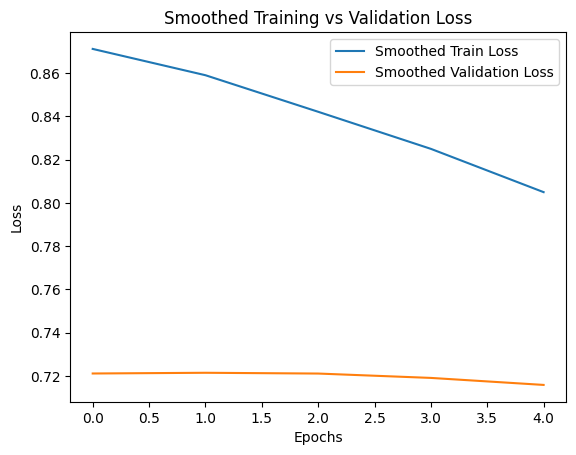

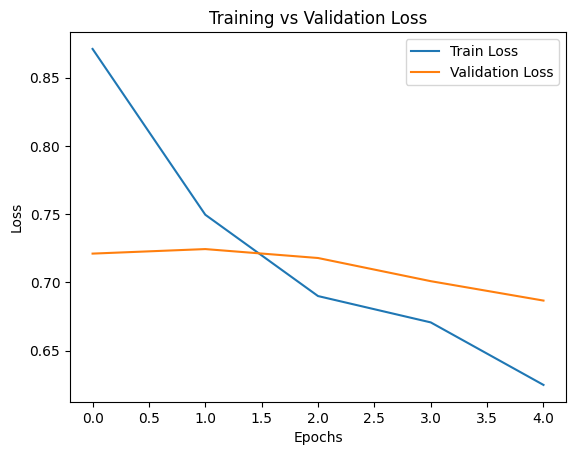

In [52]:
# Plot the training and validation loss curves
# Smooth and plot training/validation loss
smoothed_train_losses = smooth_curve(train_losses)
smoothed_val_losses = smooth_curve(val_losses)

plt.plot(smoothed_train_losses, label="Smoothed Train Loss")
plt.plot(smoothed_val_losses, label="Smoothed Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Smoothed Training vs Validation Loss")
plt.legend()
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Custom CNN

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []

    print("\nTraining Progress:")
    print("Epoch | Train Loss | Train Acc | Val Loss | Val Acc")
    print("-----------------------------------------------------")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"{epoch+1:5} | {train_loss:.4f}    | {train_acc:.4f}   | {val_loss:.4f}  | {val_acc:.4f}")

    print("Training Complete!")


    return train_losses, val_losses


In [54]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define number of classes
num_classes = 7  # Example: MEL, NV, BCC, AKIEC, BKL, DF, VASC

# Initialize the model and move it to the device
custom_model = CustomCNN(num_classes).to(device)

# Define training parameters
num_epochs = 5
learning_rate = 0.001

# Train the model
train_losses, val_losses = train_model(custom_model, train_loader, val_loader, num_epochs, learning_rate)

# Plot training vs validation loss



Training Progress:
Epoch | Train Loss | Train Acc | Val Loss | Val Acc
-----------------------------------------------------
    1 | 0.9305    | 0.6725   | 0.8280  | 0.6995
    2 | 0.7702    | 0.7179   | 0.7935  | 0.7120
    3 | 0.7141    | 0.7311   | 0.8088  | 0.7344
    4 | 0.6241    | 0.7702   | 0.7680  | 0.7506
    5 | 0.5054    | 0.8078   | 0.7478  | 0.7519
Training Complete!


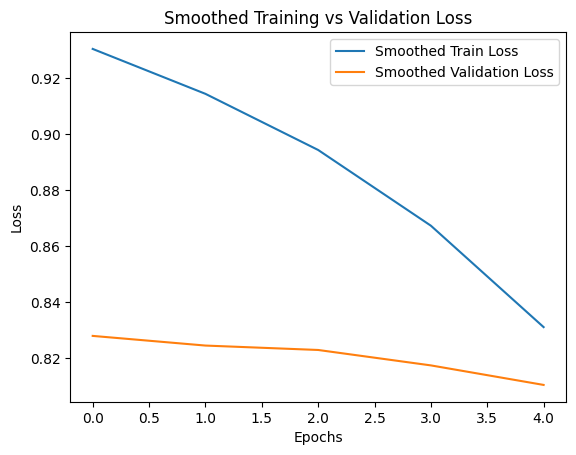

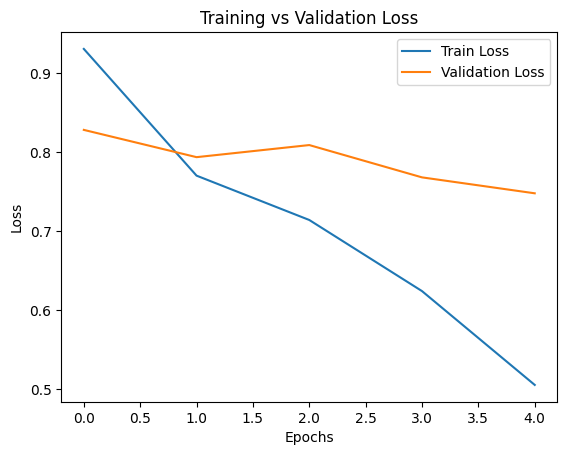

In [55]:
# Smooth and plot training/validation loss
smoothed_train_losses = smooth_curve(train_losses)
smoothed_val_losses = smooth_curve(val_losses)

plt.plot(smoothed_train_losses, label="Smoothed Train Loss")
plt.plot(smoothed_val_losses, label="Smoothed Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Smoothed Training vs Validation Loss")
plt.legend()
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Evaluation

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {acc:.4f}\n")

    # Classification Report (Precision, Recall, F1 per class)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


Test Accuracy: 0.7234

Classification Report:
              precision    recall  f1-score   support

         MEL       0.37      0.57      0.45       223
          NV       0.88      0.84      0.86      1341
         BCC       0.65      0.38      0.48       103
       AKIEC       0.31      0.69      0.43        65
         BKL       0.57      0.43      0.49       220
          DF       0.00      0.00      0.00        23
        VASC       0.86      0.64      0.73        28

    accuracy                           0.72      2003
   macro avg       0.52      0.51      0.49      2003
weighted avg       0.75      0.72      0.73      2003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


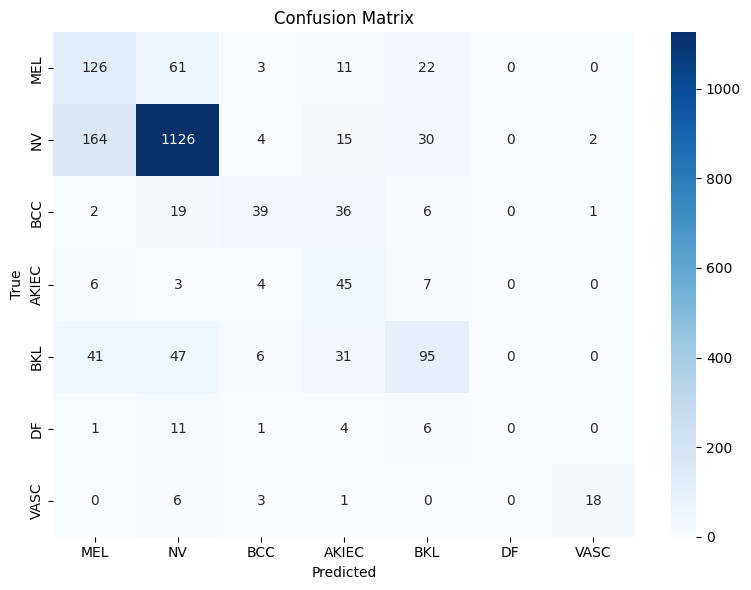

In [57]:
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

evaluate_model(model, test_loader, class_names)

# Segmentation

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))
        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))
        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final_conv(d1))


In [59]:
def dice_coef(preds, targets, smooth=1):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_score(preds, targets, smooth=1):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def train_segmentation_model(model, train_loader, val_loader, num_epochs=10, lr=0.0001):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss, total_dice, total_iou = 0, 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                preds = (outputs > 0.5).float()

                total_dice += dice_coef(preds, masks)
                total_iou += iou_score(preds, masks)

        avg_dice = total_dice / len(val_loader)
        avg_iou = total_iou / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f}")


In [60]:
def evaluate_segmentation(model, test_loader):
    model.eval()
    dice_total, iou_total = 0, 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()

            dice_total += dice_coef(preds, masks)
            iou_total += iou_score(preds, masks)

    avg_dice = dice_total / len(test_loader)
    avg_iou = iou_total / len(test_loader)
    print(f"📊 Test Dice Coefficient: {avg_dice:.4f}")
    print(f"📊 Test IoU Score: {avg_iou:.4f}")


In [61]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    count = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()

            for i in range(images.size(0)):
                if count >= num_samples:
                    return

                image = images[i].cpu().permute(1, 2, 0).numpy()
                gt_mask = masks[i][0].cpu().numpy()
                pred_mask = preds[i][0].cpu().numpy()

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title("Input Image")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(gt_mask, cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                count += 1


In [62]:
from torch.utils.data import Dataset
from PIL import Image, UnidentifiedImageError
import os
import numpy as np
import torchvision.transforms as transforms

class HAM10000SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, image_size=224):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ids = [
            f for f in sorted(os.listdir(image_dir))
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id)
        mask_path = os.path.join(self.mask_dir, image_id.replace('.jpg', '_segmentation.png'))

        try:
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
        except UnidentifiedImageError:
            print(f"Skipping unreadable image: {image_path}")
            return self.__getitem__((idx + 1) % len(self))  # Try next sample

        image = image.resize((self.image_size, self.image_size))
        mask = mask.resize((self.image_size, self.image_size))

        image = transforms.ToTensor()(image)
        mask = torch.from_numpy(np.array(mask)).float().div(255.0).unsqueeze(0)

        return image, mask


In [63]:
from torch.utils.data import DataLoader, random_split

# Update paths to your actual data locations
image_dir = f"{path}/images"
mask_dir = f"{path}/masks"

dataset = HAM10000SegmentationDataset(image_dir, mask_dir, image_size=224)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True,num_workers=8)
val_loader = DataLoader(val_set, batch_size=16,num_workers=8)
test_loader = DataLoader(test_set, batch_size=16,num_workers=8)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [64]:
model = UNet(in_channels=3, out_channels=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_segmentation_model(model, train_loader, val_loader, num_epochs=3)
evaluate_segmentation(model, test_loader)


Epoch 1/3 | Train Loss: 156.9648 | Val Loss: 18.8389 | Dice: 0.8593 | IoU: 0.7550
Epoch 2/3 | Train Loss: 73.9601 | Val Loss: 14.6803 | Dice: 0.8883 | IoU: 0.8009
Epoch 3/3 | Train Loss: 59.7451 | Val Loss: 11.8921 | Dice: 0.9042 | IoU: 0.8266
📊 Test Dice Coefficient: 0.9097
📊 Test IoU Score: 0.8356


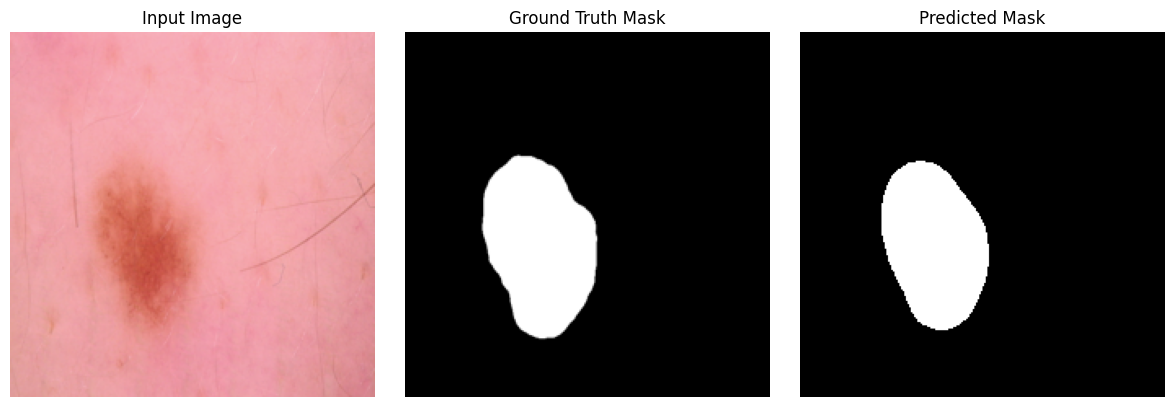

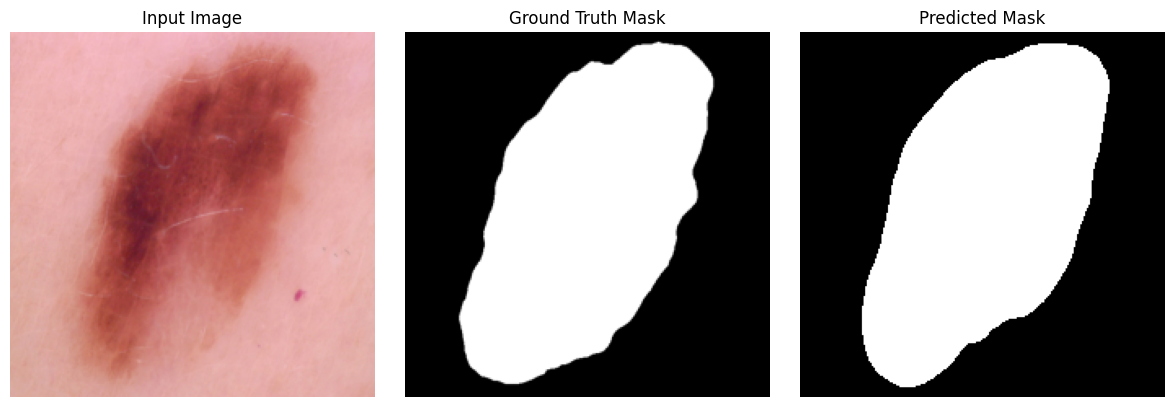

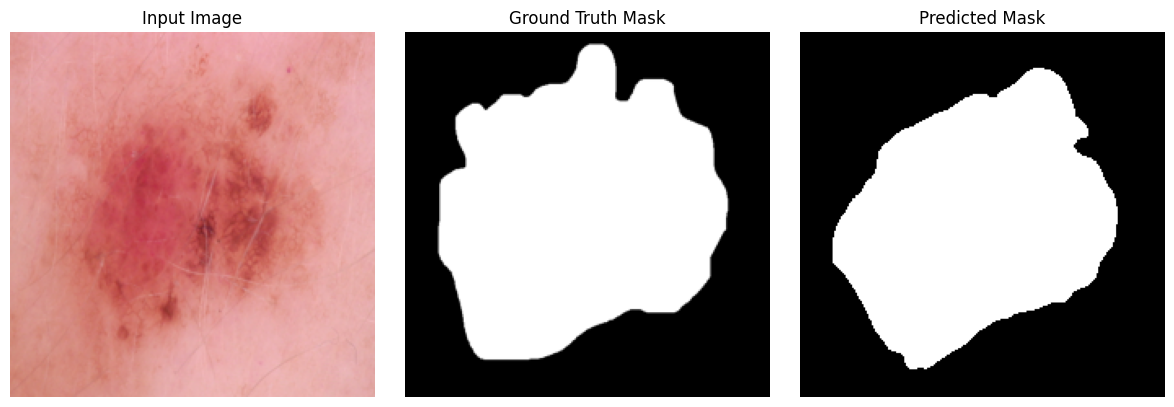

In [65]:
visualize_predictions(model, test_loader, device)

# Bonus 1

In [66]:
import os
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split

# Paths (update if yours are different)
DATA_DIR = path
IMAGE_DIR = os.path.join(DATA_DIR, "images")
MASK_DIR = os.path.join(DATA_DIR, "masks")
CSV_PATH = os.path.join(DATA_DIR, "GroundTruth.csv")

# Load CSV
df = pd.read_csv(CSV_PATH)

# Drop any rows where image or mask file is missing
df['image_path'] = df['image'].apply(lambda x: os.path.join(IMAGE_DIR, x + ".jpg"))
df['mask_path'] = df['image'].apply(lambda x: os.path.join(MASK_DIR, x + "_segmentation.png"))

df = df[df['image_path'].apply(os.path.exists)]
df = df[df['mask_path'].apply(os.path.exists)]
df['dx'] = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)

# Map class labels to integers
class_names = df['dx'].unique().tolist()
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}
df['label'] = df['dx'].map(class_to_idx)

# Extract lists
image_paths = df['image_path'].tolist()
mask_paths = df['mask_path'].tolist()
class_labels = df['label'].tolist()

# Train/val/test split
train_img, temp_img, train_lbl, temp_lbl, train_mask, temp_mask = train_test_split(
    image_paths, class_labels, mask_paths, test_size=0.3, stratify=class_labels, random_state=42)

val_img, test_img, val_lbl, test_lbl, val_mask, test_mask = train_test_split(
    temp_img, temp_lbl, temp_mask, test_size=0.5, stratify=temp_lbl, random_state=42)


In [67]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class HAM10000MultiTaskDataset(Dataset):
    def __init__(self, image_paths, class_labels, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.class_labels = class_labels
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        label = self.class_labels[idx]

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, label, mask


In [68]:
from torch.utils.data import DataLoader

# Transforms
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Dataset Instances
train_dataset = HAM10000MultiTaskDataset(train_img, train_lbl, train_mask, transform, mask_transform)
val_dataset = HAM10000MultiTaskDataset(val_img, val_lbl, val_mask, transform, mask_transform)
test_dataset = HAM10000MultiTaskDataset(test_img, test_lbl, test_mask, transform, mask_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [69]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_img, val_img, train_mask, val_mask, train_labels, val_labels = train_test_split(
    image_paths, mask_paths, class_labels, test_size=0.2, random_state=42)

train_dataset = HAM10000MultiTaskDataset(train_img, train_labels, train_mask, transform, mask_transform)
val_dataset = HAM10000MultiTaskDataset(val_img, val_labels, val_mask, transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)


In [70]:
import torch.nn as nn
import torch.nn.functional as F

class MultiTaskModel(nn.Module):
    def __init__(self, num_classes=7):
        super(MultiTaskModel, self).__init__()

        # Shared encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        # Segmentation head
        self.segmentation = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)  # Output: 224×224
        )

    def forward(self, x):
        features = self.encoder(x)
        class_out = self.classifier(features)
        seg_out = self.segmentation(features)
        return class_out, seg_out


In [71]:
def combined_loss(class_pred, class_target, seg_pred, seg_target, alpha=1.0, beta=1.0):
    cls_loss = nn.CrossEntropyLoss()(class_pred, class_target)
    seg_loss = nn.BCEWithLogitsLoss()(seg_pred, seg_target)
    return alpha * cls_loss + beta * seg_loss


In [72]:
def dice_coefficient(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    smooth = 1e-6
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def iou_score(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    smooth = 1e-6
    intersection = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets).sum(dim=(1,2,3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()


In [73]:
def train_multitask(model, train_loader, val_loader, num_epochs=10, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion_class = nn.CrossEntropyLoss()
    criterion_seg = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        model.train()
        train_loss, total_correct, total_samples = 0, 0, 0
        dice_scores, iou_scores = [], []

        for images, labels, masks in train_loader:
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)

            optimizer.zero_grad()
            out_class, out_seg = model(images)

            loss_class = criterion_class(out_class, labels)
            loss_seg = criterion_seg(out_seg, masks)
            loss = loss_class + loss_seg
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Classification Accuracy
            _, preds = torch.max(out_class, 1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            # Dice & IoU
            dice_scores.append(dice_coefficient(out_seg, masks))
            iou_scores.append(iou_score(out_seg, masks))

        train_acc = total_correct / total_samples
        avg_dice = sum(dice_scores) / len(dice_scores)
        avg_iou = sum(iou_scores) / len(iou_scores)

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Classification Accuracy: {train_acc:.4f}")
        print(f"Dice Coefficient: {avg_dice:.4f}")
        print(f"IoU Score: {avg_iou:.4f}")

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        val_dice_scores, val_iou_scores = [], []

        with torch.no_grad():
            for images, labels, masks in val_loader:
                images, labels, masks = images.to(device), labels.to(device), masks.to(device)
                out_class, out_seg = model(images)

                loss_class = criterion_class(out_class, labels)
                loss_seg = criterion_seg(out_seg, masks)
                val_loss += (loss_class + loss_seg).item()

                _, preds = torch.max(out_class, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                val_dice_scores.append(dice_coefficient(out_seg, masks))
                val_iou_scores.append(iou_score(out_seg, masks))

        val_acc = val_correct / val_total
        val_dice = sum(val_dice_scores) / len(val_dice_scores)
        val_iou = sum(val_iou_scores) / len(val_iou_scores)

        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Validation Dice Coefficient: {val_dice:.4f}")
        print(f"Validation IoU Score: {val_iou:.4f}")


In [74]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, class_names, device, num_samples=4):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for images, class_labels, seg_masks in dataloader:
            images = images.to(device)
            seg_masks = seg_masks.to(device)
            class_out, seg_out = model(images)

            preds = torch.argmax(class_out, dim=1)
            seg_preds = (seg_out > 0.5).float()

            for i in range(images.size(0)):
                if images_shown >= num_samples:
                    return

                plt.figure(figsize=(12, 3))
                plt.subplot(1, 4, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title("Image")
                plt.axis("off")

                plt.subplot(1, 4, 2)
                plt.imshow(seg_masks[i].cpu().squeeze(), cmap='gray')
                plt.title("GT Mask")
                plt.axis("off")

                plt.subplot(1, 4, 3)
                plt.imshow(seg_preds[i][0].cpu().squeeze(), cmap='gray')
                plt.title("Pred Mask")
                plt.axis("off")

                plt.subplot(1, 4, 4)
                true_label = class_names[class_labels[i].item()]
                pred_label = class_names[preds[i].item()]
                plt.text(0.5, 0.5, f"True: {true_label}\nPred: {pred_label}", fontsize=12,
                         ha='center', va='center')
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                images_shown += 1


In [75]:
model = MultiTaskModel(num_classes=7)
train_multitask(model, train_loader, val_loader, num_epochs=5, lr=1e-3)


Epoch [1/5]
Train Loss: 1.4090
Classification Accuracy: 0.6759
Dice Coefficient: 0.4495
IoU Score: 0.3701
Validation Loss: 1.2636
Validation Accuracy: 0.6555
Validation Dice Coefficient: 0.6897
Validation IoU Score: 0.5849
Epoch [2/5]
Train Loss: 1.1707
Classification Accuracy: 0.6953
Dice Coefficient: 0.6811
IoU Score: 0.5774
Validation Loss: 1.1587
Validation Accuracy: 0.7074
Validation Dice Coefficient: 0.6369
Validation IoU Score: 0.5332
Epoch [3/5]
Train Loss: 1.0612
Classification Accuracy: 0.7243
Dice Coefficient: 0.7013
IoU Score: 0.5987
Validation Loss: 1.1375
Validation Accuracy: 0.6970
Validation Dice Coefficient: 0.7322
Validation IoU Score: 0.6261
Epoch [4/5]
Train Loss: 0.9534
Classification Accuracy: 0.7530
Dice Coefficient: 0.7207
IoU Score: 0.6155
Validation Loss: 1.0829
Validation Accuracy: 0.7194
Validation Dice Coefficient: 0.7372
Validation IoU Score: 0.6324
Epoch [5/5]
Train Loss: 0.8502
Classification Accuracy: 0.7931
Dice Coefficient: 0.7305
IoU Score: 0.6236
Va

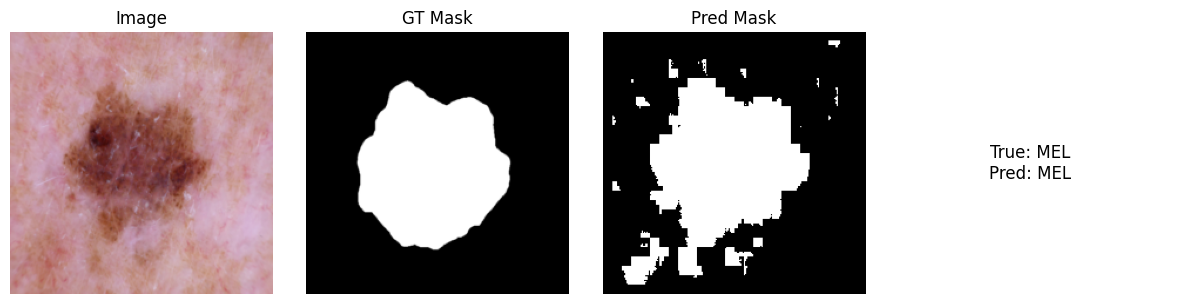

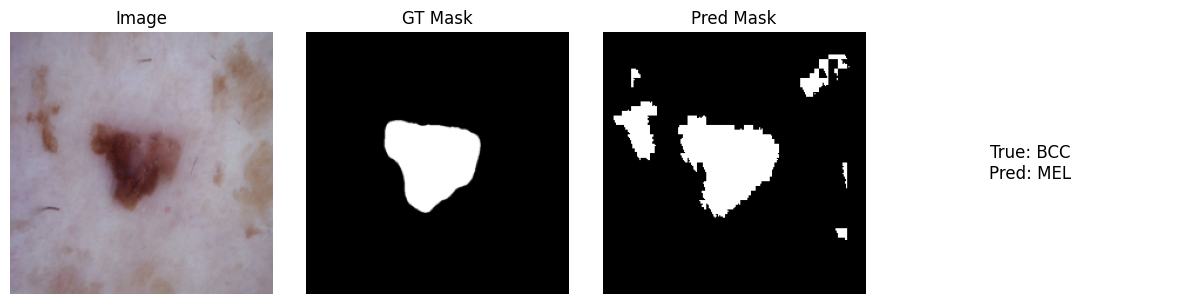

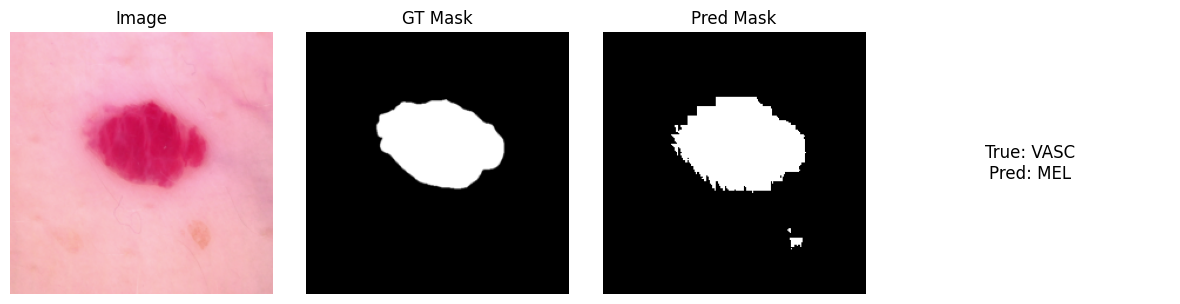

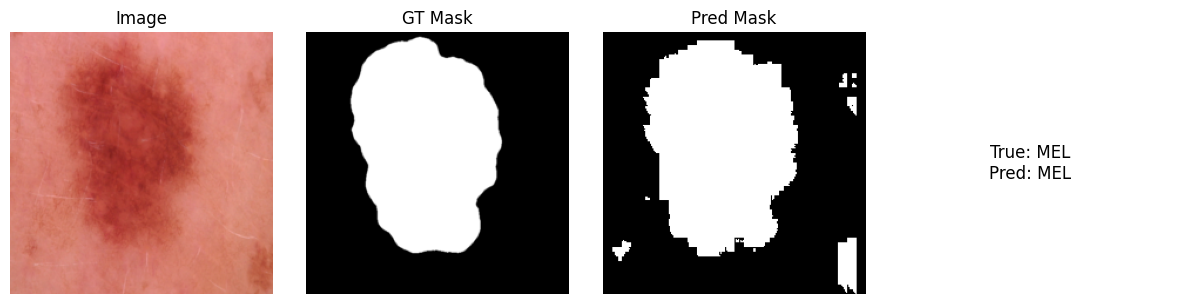

In [76]:
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
visualize_predictions(model, test_loader, class_names, device)